# Assignment 3 - Supervised Classification

## Objectives

Supervised classification has been performed on the provided **Sentinel-2** image to identify and categorize different land covers. The following procedure has been followed:
1. Visualizing the provided image to decide on the number of relevant land cover classes.
2. Manually sampling pixel coordinates (row, column) of all land covers and creating separate lists.
3. Creating an ROI from land cover lists and feeding to the forked code to perform Supervised Classification using **Random Forest**.
4. Checking the accuracy of the trained model using **Out-of-Bag** score, which is more suited than the classic **precision**, **recall**, and **accuracy** metrics for this case.
5. Checking the effect of number of classes on model performance.
6. Re-implementing and re-evaluating the model with data collected from all classmates and comparing the performance with independently-collected-data model.

The **code** provided in the class was utilized for the visualization and classification processes.

https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

## Visualization and Label Creation

First, the relevant libraries have been imported.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt

The **color_stretch** function has been defined to amplify the image colors for better visibility.

In [2]:
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors

Then, the image (packaged within an **npz** file) has been loaded and stretched. For data sampling, this block of code was ran with the **%matplotlib qt** backend which displays the pixel coordinates as (column [x], row [y]) at the top-left of its native GUI and allows interactive zooming and panning.

**NOTE**: The backend has been commented out at the end to revert to static image that can be displayed in-line.

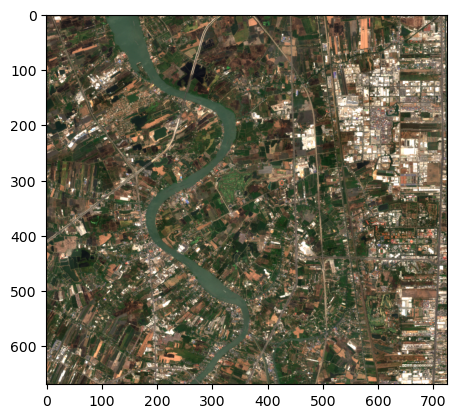

In [3]:
# %matplotlib qt
inp = np.load("data.npz")
img = inp['arr_0']
img_p = color_stretch(img,[3,2,1],(0,0.3))
plt.imshow(img_p)
plt.show()

From the image, at least 5 classes can be clearly distinguised:
* Vegetation
* Water
* Barren
* Urban
* Road

A numpy array has been created for the **ROI**, masking the original image-size, which is used to store the label-categories and then train the model.

In [4]:
roi = np.zeros((img.shape[0],img.shape[1]), dtype=int)
print(roi.shape)

(669, 725)


After sampling and collecting data manually for different landcovers, lists have been defined for each cover.

In [5]:
vegetated = [[411,310],[600,572],[604,572],[55,40],[49,49],[108,68],[116,77],[61,78],[103,54],[103,18],[285,148],[238,82],[224,126],[329,96],[368,113],[364,168],[224,177],[507,263],[494,277],[495,211],[482,265],[521,276],[495,206],[299,234],[287,233],[279,223],[241,229],[223,273],[302,258],[311,232],[287,274],[301,200],[324,326],[344,314],[374,329],[353,298],[314,315],[310,344],[317,352],[361,348],[282,356],[294,308],[362,360],[353,422],[414,396],[417,429],[304,397],[431,381],[345,428],[340,454],[345,417],[459,484],[513,424],[511,386],[502,396],[527,435],[524,444],[515,256],[506,262],[497,256],[470,186],[460,237]]
water = [[72,434],[139,13],[157,90],[192,370],[198,341],[198,401],[236,436],[241,143],[248,306],[268,296],[286,286],[289,472],[303,495],[312,256],[312,616],[327,193],[327,510],[337,596],[345,515],[358,575],[361,323],[362,549],[363,334],[403,312],[404,312],[634,172],[67,453],[568,273],[598,582],[611,590],[556,533],[559,507],[557,488],[556,480],[552,457],[543,503]]
barren = [[4,434],[7,497],[18,420],[31,428],[33,415],[40,410],[55,470],[81,505],[88,501],[115,472],[118,459],[272,54],[278,26],[278,136],[282,20],[302,68],[305,419],[307,31],[313,30],[320,405],[323,374],[324,29],[338,45],[346,359],[349,53],[350,88],[351,341],[358,84],[364,89],[367,226],[371,316],[378,125],[380,406],[381,255],[406,249],[409,83],[411,300],[414,301],[420,290],[432,64],[435,122],[435,272],[436,248],[441,298],[474,367],[479,324],[493,265],[513,9],[524,63],[527,12],[230,412]]
urban = [[514,40],[522,106],[522,46],[535,161],[555,160],[572,44],[576,10],[577,17],[578,56],[582,173],[584,11],[585,195],[587,195],[595,220],[597,189],[598,189],[600,172],[602,214],[615,191],[629,190],[633,269],[643,307],[645,297],[653,290],[662,146],[712,264],[598,191],[559,241],[565,248],[576,244],[595,256],[565,259],[552,260],[559,325],[658,573],[715,546],[647,646],[640,644],[714,657],[717,665],[650,545],[432,262],[493,252],[420,295],[382,439],[345,452],[353,446],[180,590],[221,624],[120,571],[93,606],[236,584],[187,428],[75,583],[221,653],[216,350]]
road = [[503,485],[502,469],[501,454],[500,441],[500,432],[499,419],[498,410],[497,406],[496,387],[495,358],[493,341],[491,312],[491,294],[490,281],[490,271],[489,259],[263,113],[266,100],[269,87],[271,80],[277,59],[282,44],[287,31],[295,19],[262,81],[257,78],[251,74],[246,70],[236,58],[231,48],[304,105],[180,275],[189,269],[226,235],[154,276],[146,267],[140,257],[132,246],[126,239],[117,227],[110,218],[106,213],[99,204],[89,190],[84,181],[314,157],[318,153],[322,149],[327,144],[334,138],[342,133],[716,188],[716,197],[716,207],[716,223],[719,226],[226,231]]
labels = [vegetated, water, barren, urban, road]

Then, these labels have been mapped to the ROI-mask.

In [6]:
for label in labels:
    for yy,xx in label:
        roi[xx,yy] = labels.index(label)+1

This has been written to a file **Aaryan_ROI.npy** for convenient extraction.

## Implementation with Independent ROI

### Initial Model with 5 label classes

#### Training and Testing

Only the pixels with labels are relevant to the training. Therefore, these have been extracted to **X** and **y**.

In [7]:
X = img[roi > 0,:]
y = roi[roi > 0]

A random forest classifier has been instantiated and fit to this specific data. The **Out-of-Bag** score has also been displayed.

In [8]:
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)
rf = rf.fit(X,y)

print(f"Out of Bag Score: {100*rf.oob_score_:.2f}%")

Out of Bag Score: 79.39%


Now, to classify using this model, the original image has been unravelled to a series of inputs per band.

In [9]:
new_shape = (img.shape[0]*img.shape[1],img.shape[2])
img_as_array = img.reshape(new_shape)

Then, the predictions have been made using the trained model.

In [10]:
class_prediction = rf.predict(img_as_array)

For the resulting classified map, colors have been pre-defined into the **get_cmap** function. Therefore, for further usage, this function has been defined here.

In [11]:
def get_cmap(class_prediction):
    n = class_prediction.max()
    # Next setup a colormap for our map
    colors = dict((
        (0, (0, 0, 0, 255)),  # Nodata
        (1, (0, 150, 0, 255)),  # Vegetated
        (2, (0, 0, 255, 255)),  # Water
        (3, (160, 82, 45, 255)),  # Barren
        (4, (255, 0, 0, 255)),  # Urban
        (5, (128,128,128,255)) # Road
    ))
    # Put 0 - 255 as float 0 - 1
    for k in colors:
        v = colors[k]
        _v = [_v / 255.0 for _v in v]
        colors[k] = _v
        
    index_colors = [colors[key] if key in colors else 
                    (255, 255, 255, 0) for key in range(1, n + 1)]
    cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

    return cmap

Finally, the original image (stretched for visibility) has been illustrated alongside the classified image for visual evaluation.

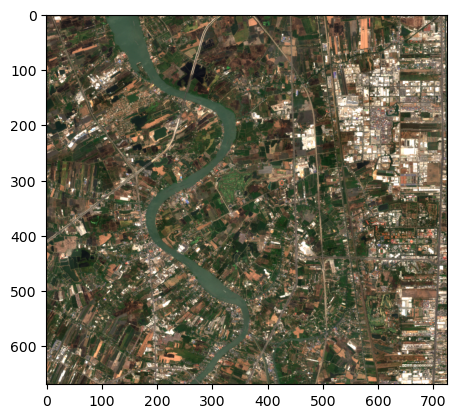

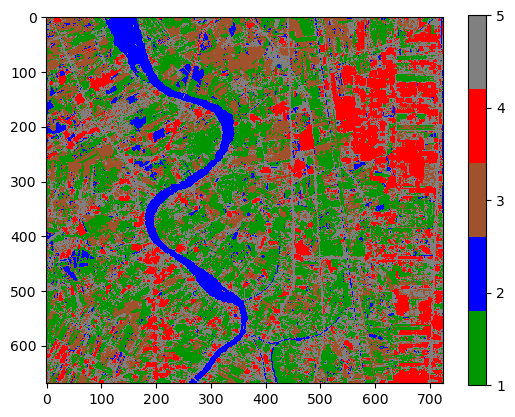

In [12]:
class_prediction = class_prediction.reshape(img[:,:,0].shape)

img_p = color_stretch(img,[3,2,1],(0,0.3))
cmap = get_cmap(class_prediction)

plt.imshow(img_p)
plt.show()
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.colorbar(ticks=np.arange(1,5+1))
plt.show()

The classificaiton is farily accurate upon visual inspection.

#### Band Importance

Although all 8 bands have fed to this model during the training, there are possibilities of some being irrelvant. To check this, the **rf.feature_importances** attribute has been extracted from the trained model.

In [13]:
for band, importance in zip(range(1,9),rf.feature_importances_):
    print(f"Band {band}: {100*importance:.2f}%")

Band 1: 13.88%
Band 2: 13.98%
Band 3: 9.13%
Band 4: 15.53%
Band 5: 11.55%
Band 6: 11.29%
Band 7: 12.42%
Band 8: 12.22%


Although Bands 1, 2 and 4 have shown a higher importance percentage, the maximum and minimum contributions are not significantly different, therefore, it is better to include all bands.

### Test Model with 4 label classes

The resulting map from the 5-classes model has predicted several overlapping and fuzzy areas of **road** and **urban** classes. Therefore, the model might have benefitted from unifying these into a single **urban** class. To test this, the previous code blocks have been reimplemented, and the **OOB** scores and the final Maps have been replotted.

In [14]:
# Replacing Roads (5) with Urban (4) labels
roi[roi==5]=4
y = roi[roi > 0]

rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)
rf = rf.fit(X,y)

print(f"Out of Bag Score: {100*rf.oob_score_:.2f}%")

Out of Bag Score: 84.35%


An increase was seen in the **OOB** score upon reduction of number of label classes.

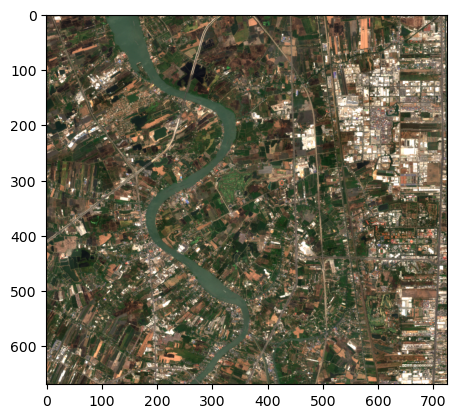

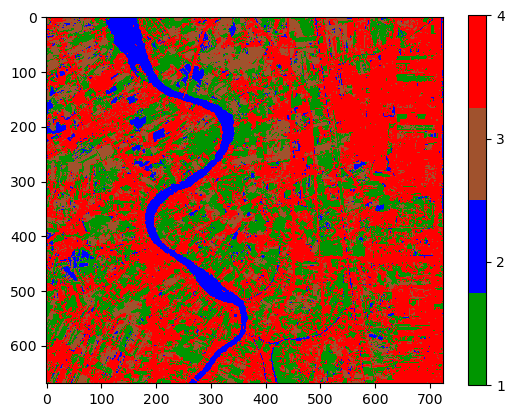

In [15]:
class_prediction = rf.predict(img_as_array)

class_prediction = class_prediction.reshape(img[:,:,0].shape)

img_p = color_stretch(img,[3,2,1],(0,0.3))
cmap = get_cmap(class_prediction)

plt.imshow(img_p)
plt.show()
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.colorbar(ticks=np.arange(1,5+1))
plt.show()

Although the OOB score increased for 4 classes, it is also notable that less information can be extracted from the final map. Therefore, 5 classes are better than 4 despite the slight increase in accuracy. However, it is also unlikely that adding significantly more classes of labels can improve the model as it promotes training potential **noise** to a class while being unable to amply differentiate between the blurs of two classes.

## Implementation with Merged ROI Data

Overall data sampled by the class has been retrieved from textfiles into numpy arrays.

In [16]:
_vegetated = np.loadtxt("vegetation.txt")
_water = np.loadtxt("water_bodies.txt")
_barren = np.loadtxt("barren.txt")
_urban = np.loadtxt("urban.txt")
_road = np.loadtxt("road.txt")
_labels = [_vegetated, _water, _barren, _urban, _road]

These label classes have been assigned to the **roi** mask.

In [17]:
index = 1
for label in _labels:
    for yy,xx in label:
        roi[int(xx),int(yy)] = index
    index+=1

The ROI has been written to a file named **ROI_All.npy**.

Thereafter, the previous blocks have been re-implemented to obtain the **OOB** scores and the final map.

In [18]:
X = img[roi > 0,:]
y = roi[roi > 0]

_rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)
_rf = _rf.fit(X,y)
print(f"Out of Bag Score: {100*_rf.oob_score_:.2f}%")

Out of Bag Score: 82.82%


The **OOB** score has increased from the case of individual training. As expected, more data samples seem to improve the model performance. 

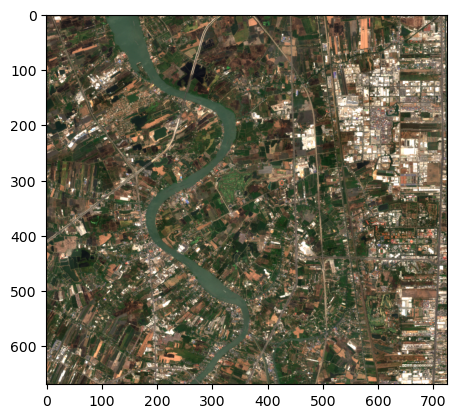

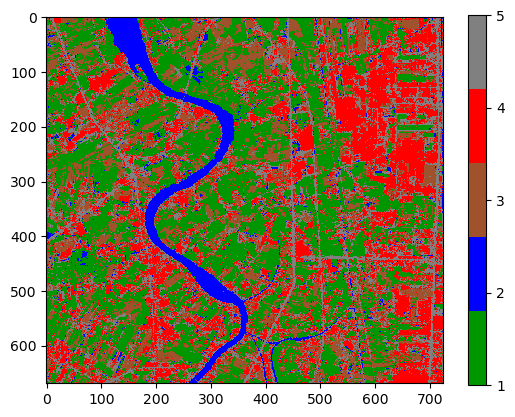

In [19]:
class_prediction = _rf.predict(img_as_array)

class_prediction = class_prediction.reshape(img[:,:,0].shape)

img_p = color_stretch(img,[3,2,1],(0,0.3))
cmap = get_cmap(class_prediction)

plt.imshow(img_p)
plt.show()
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.colorbar(ticks=np.arange(1,5+1))
plt.show()

The final map has a better reproduction of the roads and urban areas. However, it does seem to discount and blur many water bodies, and mistake those with vegetation covers. A final check has been made for the band importance in this model as well.

In [20]:
for band, importance in zip(range(1,9),_rf.feature_importances_):
    print(f"Band {band}: {100*importance:.2f}%")

Band 1: 17.18%
Band 2: 15.20%
Band 3: 9.62%
Band 4: 15.61%
Band 5: 10.45%
Band 6: 9.79%
Band 7: 10.72%
Band 8: 11.44%


The band importance with overall data shows similar proportions of importance compared to the individually trained case.